## SWIN Transformer Plant Disease Detector

### Determine Environment

In [2]:
import sys

# determine operating environment
def is_colab():
    return 'google.colab' in sys.modules

if is_colab():
    print("Running on Google Colab")
else:
    print("Running in a local environment")

Running in a local environment


### Import Libraries

In [34]:
# Google Colab does not have torchinfo or timm installed various GPU runtimes
if is_colab():
    !pip install torchinfo
    !pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import os
import shutil
import random
import timm
import json
import numpy as np

from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchinfo import summary
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Initial Setup / Hyperparameters

In [6]:
colab_directory = "/content/drive/MyDrive"
clean_directory = "PlantVillage"
split_directory = "PlantVillage_Split"

if is_colab():
    clean_directory = os.path.join(colab_directory, clean_directory)
    split_directory = os.path.join(colab_directory, split_directory)

training_data_directory = os.path.join(split_directory, "training")
validation_data_directory = os.path.join(split_directory, "validation")
test_data_directory = os.path.join(split_directory, "test")

seed_value = 27

class_names = [
 'Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

number_of_classes = len(class_names)
batch_size = 32
image_size = 224
patch_size = 16
number_of_workers = 4
number_of_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embedding_dimension = 768

training_split = .7
validation_split = .2
test_split = .1

In [7]:
# mount Google Drive
if is_colab():
  from google.colab import drive
  drive.mount('/content/drive')
else:
    print("executing locally...skipping")

executing locally...skipping


In [ ]:
# if dataset does not exist extract from my Google Drive (split version)
if is_colab() and not os.path.exists(split_directory):
    import zipfile
    with zipfile.ZipFile(split_directory, 'r') as zip_ref:
        zip_ref.extractall(colab_directory)

### Split PlantVillage Data Into Training, Validation, and Test Folders

In [8]:
# Only call if dataset folders do not exist
if (os.path.isdir(training_data_directory) and
    os.path.isdir(validation_data_directory) and
    os.path.isdir(test_data_directory)
):
    print(f"Dataset appears to exist...skipping.")
else:
      # create folders
      folders = ['training', 'validation', 'test']
      for folder in folders:
          os.makedirs(os.path.join(split_directory, folder), exist_ok=True)
    
      # loop over classes
      for class_name in tqdm(class_names, desc="Split Classes"):
          path = os.path.join(clean_directory, class_name)
          images = os.listdir(path)
          random.shuffle(images)
    
          # determine number of images in the current class
          image_count = len(images)
          train_count = int(image_count * training_split)
          validation_count = int(image_count * validation_split)
    
          splits = {
              'training': images[:train_count],
              'validation': images[train_count:train_count + validation_count],
              'test': images[train_count + validation_count:]
          }
    
          # copy files to directory for class
          for split in splits:
              target_directory = os.path.join(split_directory, split, class_name)
              os.makedirs(target_directory, exist_ok=True)
    
              # copy file
              for image in splits[split]:
                  source = os.path.join(path, image)
                  destination = os.path.join(target_directory, image)
                  shutil.copy(source, destination)

Dataset appears to exist...skipping.


### Data Transforms

In [8]:
# Augment training data with flips and rotation
training_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(image_size,image_size), scale=(0.9, 1.0)),
    transforms.ColorJitter(hue=0.5, saturation=0.5, brightness=0.2, contrast=0.2),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

validation_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

### Load Datasets

In [9]:
training_dataset = datasets.ImageFolder(training_data_directory, transform=training_transform)
validation_dataset = datasets.ImageFolder(validation_data_directory, transform=validation_test_transform)

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=number_of_workers)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=number_of_workers)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
# Custom classification head to fix issues with label smoothing
class CustomHead(nn.Module):
    def __init__(self, in_features, num_classes, dropout_prob=0.4):
        super(CustomHead, self).__init__()
        self.norm = nn.LayerNorm(in_features)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = x.mean(dim=1)
        x = self.norm(x)
        x = self.dropout(x)
        return self.fc(x)

### Configure Pretrained SWIN Transformer

In [11]:
# Create a model from the timm library with a patch size of 4x4, window size
# of 7x7, and expected image size input of 224x224.
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

# replace default head with custom head
in_features = model.head.in_features
model.head = CustomHead(in_features, number_of_classes)

model = model.to(device)

# add label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=.1)

# implement optimizer with AdamW algorithm and learning rate of .0001
optimizer = optim.AdamW(model.parameters(), lr=.0001)

### Define Evaluation Function

In [12]:
# Evaluates performance based on number of correctly predicted images vs total images
def evaluate_model(loader, name: str):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).mean(dim=1)
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total

    print(f"{name} Accuracy: {100 * accuracy:.2f}%")

    return accuracy

### Model Summary

In [13]:
# Use torchinfo to display information about the model
summary(model,
        input_size=(1, 3, image_size, image_size),
        col_names=["input_size", "output_size", "num_params"]
)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
SwinTransformer                                    [1, 3, 224, 224]          [1, 7, 38]                --
├─PatchEmbed: 1-1                                  [1, 3, 224, 224]          [1, 56, 56, 96]           --
│    └─Conv2d: 2-1                                 [1, 3, 224, 224]          [1, 96, 56, 56]           4,704
│    └─LayerNorm: 2-2                              [1, 56, 56, 96]           [1, 56, 56, 96]           192
├─Sequential: 1-2                                  [1, 56, 56, 96]           [1, 7, 7, 768]            --
│    └─SwinTransformerStage: 2-3                   [1, 56, 56, 96]           [1, 56, 56, 96]           --
│    │    └─Identity: 3-1                          [1, 56, 56, 96]           [1, 56, 56, 96]           --
│    │    └─Sequential: 3-2                        [1, 56, 56, 96]           [1, 56, 56, 96]           224,694
│    └─SwinTransformerStage: 2-4

### Train Pretrained SWIN Transformer on PlantVillage Dataset

In [14]:
# Create object to store values throughout training
history = {
    "training_loss": [],
    "training_accuracy": [],
    "validation_accuracy": []
}

# Training Loop
# Loop for each epoch
for epoch in range(number_of_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Conduct learning on the training dataset
    for images, labels in tqdm(training_dataloader, desc=f"Epoch {epoch+1}/{number_of_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.mean(dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Calulate and display training loss, training set accuracy, and validation set accuracy
    training_loss = running_loss / len(training_dataloader)

    print(f"Epoch {epoch+1}/{number_of_epochs}\n-----------------------------------------")
    print(f"Training Loss: {training_loss:.4f}")
    training_accuracy = evaluate_model(training_dataloader, "Training")
    validation_accuracy = evaluate_model(validation_dataloader, "Validation")

    # Record values into history object
    history["training_loss"].append(training_loss)
    history["training_accuracy"].append(training_accuracy)
    history["validation_accuracy"].append(validation_accuracy)

# Added save to this cell due to timeout disconnects.
if is_colab():
    model_save_path = os.path.join(colab_directory, "swin_model_10_epochs.pth")
    history_save_path = os.path.join(colab_directory, "history.json")
else:
    model_save_path = "swin_model_10_epochs.pth"
    history_save_path = "history.json"

torch.save(model.state_dict(), model_save_path)
print("model saved.")

with open(history_save_path, 'w') as f:
    json.dump(history, f, indent=4)
print("history saved.")

Epoch 1/10: 100%|██████████| 1188/1188 [1:13:49<00:00,  3.73s/it]

Epoch 1/10
-----------------------------------------
Training Loss: 1.0387


Training Accuracy: 94.83%
Validation Accuracy: 96.28%


Epoch 2/10: 100%|██████████| 1188/1188 [09:18<00:00,  2.13it/s]

Epoch 2/10
-----------------------------------------
Training Loss: 0.8191


Training Accuracy: 97.11%
Validation Accuracy: 98.70%


Epoch 3/10: 100%|██████████| 1188/1188 [09:16<00:00,  2.14it/s]

Epoch 3/10
-----------------------------------------
Training Loss: 0.7883


Training Accuracy: 96.74%
Validation Accuracy: 98.38%


Epoch 4/10: 100%|██████████| 1188/1188 [09:10<00:00,  2.16it/s]

Epoch 4/10
-----------------------------------------
Training Loss: 0.7728


Training Accuracy: 96.33%
Validation Accuracy: 98.13%


Epoch 5/10: 100%|██████████| 1188/1188 [09:21<00:00,  2.12it/s]

Epoch 5/10
-----------------------------------------
Training Loss: 0.7641


Training Accuracy: 97.57%
Validation Accuracy: 98.48%


Epoch 6/10: 100%|██████████| 1188/1188 [09:18<00:00,  2.13it/s]

Epoch 6/10
-----------------------------------------
Training Loss: 0.7564


Training Accuracy: 97.71%
Validation Accuracy: 98.37%


Epoch 7/10: 100%|██████████| 1188/1188 [09:16<00:00,  2.14it/s]

Epoch 7/10
-----------------------------------------
Training Loss: 0.7502


Training Accuracy: 97.93%
Validation Accuracy: 98.69%


Epoch 8/10: 100%|██████████| 1188/1188 [09:14<00:00,  2.14it/s]

Epoch 8/10
-----------------------------------------
Training Loss: 0.7520


Training Accuracy: 97.67%
Validation Accuracy: 98.29%


Epoch 9/10: 100%|██████████| 1188/1188 [09:15<00:00,  2.14it/s]

Epoch 9/10
-----------------------------------------
Training Loss: 0.7427


Training Accuracy: 97.93%
Validation Accuracy: 98.59%


Epoch 10/10: 100%|██████████| 1188/1188 [09:24<00:00,  2.11it/s]

Epoch 10/10
-----------------------------------------
Training Loss: 0.7433


Training Accuracy: 98.24%
Validation Accuracy: 99.11%


### Save Model

In [42]:
if is_colab():
    model_save_path = os.path.join(colab_directory, "swin_model_10_epochs.pth")
else:
    model_ save_path = "swin_model_10_epochs.pth"

torch.save(model.state_dict(), save_path)
print("model saved.")

### Save History

In [ ]:
if is_colab():
    history_save_path = os.path.join(colab_directory, "history.json")
else:
    history_save_path = "history.json"

with open(history_save_path, 'w') as f:
    json.dump(history, f, indent=4)
print("history saved.")

### Reload Model

In [44]:
# Only necessary if the notebook service has been restarted.
if 'model' in globals():
    print("Your model is already loaded...skipping")
else:
    if is_colab():
        model_save_path = os.path.join(colab_directory, "swin_model_10_epochs.pth")
    else:
        model_ save_path = "swin_model_10_epochs.pth"

    model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=number_of_classes)
        # replace with custom head
    in_features = model.head.in_features
    model.head = CustomHead(in_features, number_of_classes)
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model = model.to(device)
    model.eval()

your model is already loaded...skipping


### Accuracy Visualization

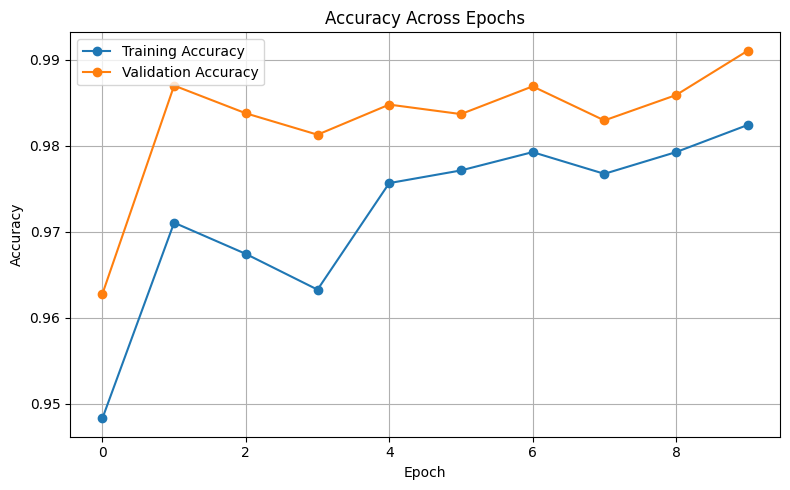

In [45]:
# Use history object to display a graph of accuracy over the course of the traing epochs
training_accuracy = history["training_accuracy"]
validation_accuracy = history["validation_accuracy"]

plt.figure(figsize=(8, 5))
plt.plot(training_accuracy, label="Training Accuracy", marker='o')
plt.plot(validation_accuracy, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Across Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluate Against Test Dataset

In [28]:
# Determine the number of predictions that were correct versus total
test_dataset = datasets.ImageFolder(test_data_directory, transform=validation_test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=number_of_workers)

model.eval()

total_predictions = []
total_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).mean(dim=1)
        _, predictions = torch.max(outputs, dim=1)
        probabilities = torch.softmax(outputs, dim=1)
        total_predictions.extend(predictions.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())


### Model Metrics

#### Test Set Accuracy

In [29]:
test_accuracy = accuracy_score(total_labels, total_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 99.25%


#### Classification Report

In [30]:
print(classification_report(total_labels, total_predictions, target_names=class_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.97      0.98        63
                                 Apple___Black_rot       1.00      1.00      1.00        63
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        28
                                   Apple___healthy       1.00      0.99      0.99       165
                               Blueberry___healthy       0.99      1.00      1.00       151
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       106
                 Cherry_(including_sour)___healthy       1.00      0.98      0.99        87
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.98      0.96        52
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       120
               Corn_(maize)___Northern_Leaf_Blight       0.99      0.98      0.

#### Confusion Matrix

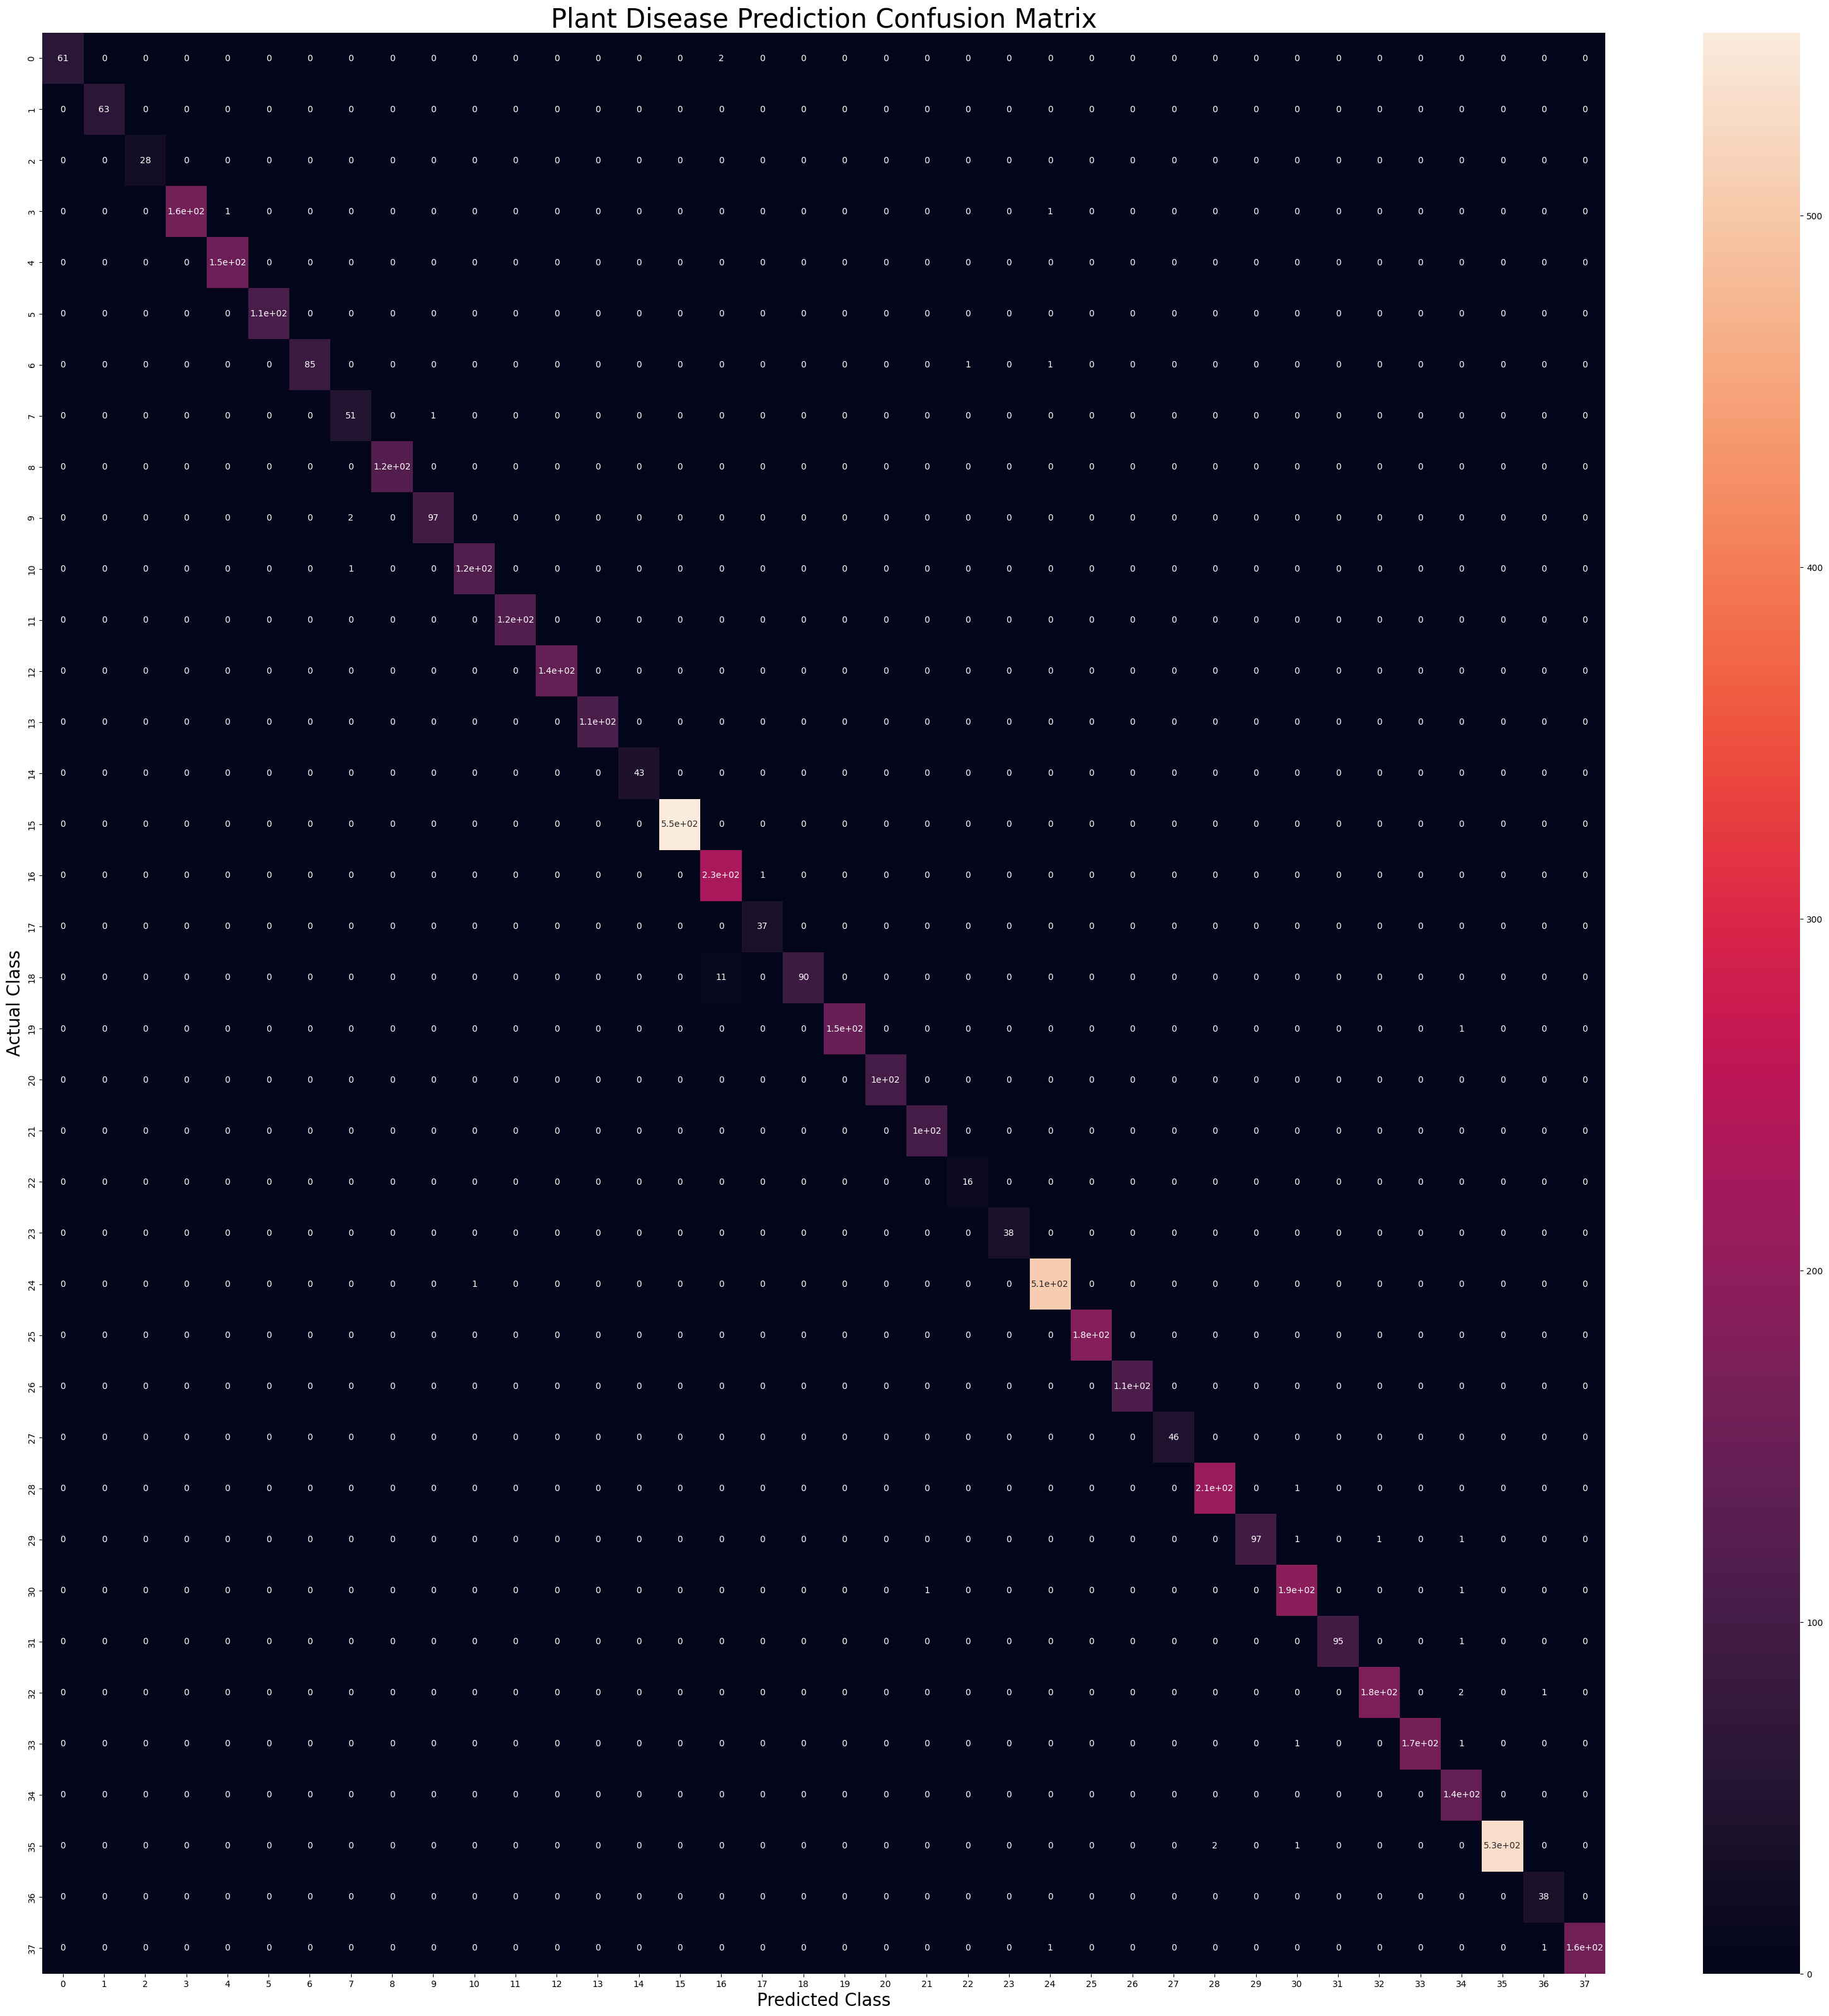

In [31]:
matrix = confusion_matrix(total_labels, total_predictions)

plt.figure(figsize=(40,40))
sns.heatmap(matrix, annot=True, annot_kws={'size':10})
plt.xlabel("Predicted Class", fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title("Plant Disease Prediction Confusion Matrix", fontsize=30)
plt.show()